In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from faker import Faker
from ctgan import CTGAN
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
fake = Faker()
Faker.seed(42)

print("Creating cross-border transaction dataset...")

Creating cross-border transaction dataset...


In [9]:
# Define countries with their risk levels (1-10, where 10 is highest risk)
countries = {
    'USA': 2, 'UK': 2, 'Canada': 2, 'Australia': 2, 'Germany': 2, 
    'France': 3, 'Japan': 2, 'Singapore': 2, 'Switzerland': 3, 'UAE': 4,
    'India': 5, 'China': 5, 'Brazil': 6, 'Mexico': 6, 'Russia': 7,
    'Turkey': 6, 'South Africa': 5, 'Nigeria': 8, 'Pakistan': 7, 'Iran': 9,
    'North Korea': 10, 'Venezuela': 8, 'Cuba': 7, 'Myanmar': 8, 'Syria': 9,
    'Cayman Islands': 6, 'British Virgin Islands': 6, 'Panama': 6, 'Bahamas': 6  # Added missing countries
}

# Define currencies with their risk levels
currencies = {
    'USD': 1, 'EUR': 1, 'GBP': 1, 'CAD': 1, 'AUD': 1, 
    'JPY': 1, 'CHF': 1, 'SGD': 2, 'CNY': 3, 'INR': 3,
    'RUB': 5, 'BRL': 4, 'MXN': 4, 'TRY': 5, 'ZAR': 4,
    'NGN': 6, 'PKR': 6, 'IRR': 8, 'KPW': 10, 'VES': 7
}

# Transaction types
transaction_types = ['SWIFT', 'Wire Transfer', 'ACH', 'SEPA', 'CHAPS', 'Fedwire', 'RTGS']

# Purpose codes
purpose_codes = [
    'Business Payment', 'Personal Transfer', 'Investment', 'Property Purchase',
    'Education Fees', 'Medical Expenses', 'Travel Expenses', 'Family Support',
    'Consulting Services', 'Goods Purchase', 'Loan Repayment', 'Salary Payment',
    'Dividend Payment', 'Royalty Payment', 'Charity Donation'
]

# KYC status options
kyc_status_options = ['FULL', 'PARTIAL', 'PENDING', 'EXPIRED', 'REJECTED']

# Devices used
devices = ['Web Browser', 'Mobile App', 'Branch Visit', 'API', 'Third-party Service']

# Sanctions check status
sanctions_status = ['CLEARED', 'FLAGGED', 'PENDING_REVIEW', 'BLOCKED']

# Correspondent banks
correspondent_banks = [
    'CITI001', 'HSBC002', 'JPMC003', 'BARC004', 'DEUT005', 
    'BNPP006', 'STCH007', 'UBSW008', 'BOFA009', 'WEST010',
    None, None, None, None  # Adding None values for direct transfers
]

# Fraud patterns
fraud_patterns = [
    'sanctioned_country',
    'large_transaction',
    'unusual_corridor',
    'suspicious_purpose',
    'kyc_issues',
    'ip_mismatch',
    'high_risk_currency',
    'money_laundering',
    'terrorist_financing',
    'sanctions_evasion',
    'shell_company',
    'smurfing',
    'round_dollar_amounts',
    'rapid_movement'
]


# Define the number of samples for seed data
num_samples = 5000
fraud_ratio = 0.4  # 40% of transactions will be fraudulent
num_fraud = int(num_samples * fraud_ratio)
num_legit = num_samples - num_fraud

def generate_seed_data(num_samples=5000, fraud_ratio=0.4):
    data = []
    
    # Calculate number of fraud and legitimate transactions
    num_fraud = int(num_samples * fraud_ratio)
    num_legit = num_samples - num_fraud
    
    # Generate account numbers
    customer_accounts = [f"ACC{str(i).zfill(8)}" for i in range(1, 501)]
    recipient_accounts = [f"REC{str(i).zfill(8)}" for i in range(1, 1001)]
    
    # Generate timestamps over the past 2 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)
    date_range = (end_date - start_date).days
    
    # Generate legitimate transactions
    for i in range(num_legit):
        # Basic transaction details
        transaction_id = f"TXN{str(i+1).zfill(10)}"
        customer_account = random.choice(customer_accounts)
        recipient_account = random.choice(recipient_accounts)
        
        # Countries and currencies - bias towards lower risk for legitimate transactions
        sender_country_list = list(countries.keys())
        sender_weights = [1/countries[c] for c in sender_country_list]  # Lower risk countries more likely
        sender_country = random.choices(sender_country_list, weights=sender_weights, k=1)[0]
        
        recipient_country_list = list(countries.keys())
        recipient_weights = [1/countries[c] for c in recipient_country_list]
        recipient_country = random.choices(recipient_country_list, weights=recipient_weights, k=1)[0]
        
        # Transaction amount (log-normal distribution for realistic amounts)
        transaction_amount = np.random.lognormal(mean=8, sigma=1.2)
        
        # Select currency - bias towards major currencies for legitimate transactions
        currency_list = list(currencies.keys())
        currency_weights = [1/currencies[c] for c in currency_list]
        transaction_currency = random.choices(currency_list, weights=currency_weights, k=1)[0]
        
        # Base currency amount (assuming USD)
        conversion_rate = random.uniform(0.5, 2.0)
        if transaction_currency == 'USD':
            base_currency_amount = transaction_amount
        else:
            base_currency_amount = transaction_amount * conversion_rate
        
        # Timestamp
        random_days = random.randint(0, date_range)
        transaction_timestamp = (start_date + timedelta(days=random_days, 
                                                      hours=random.randint(0, 23),
                                                      minutes=random.randint(0, 59),
                                                      seconds=random.randint(0, 59))).strftime('%Y-%m-%d %H:%M:%S')
        
        # Transaction type - more likely to use standard methods for legitimate
        tx_type = random.choice(transaction_types)
        
        # Purpose code - more likely to be standard purposes
        standard_purposes = ['Personal Transfer', 'Education Fees', 'Medical Expenses', 
                           'Travel Expenses', 'Family Support', 'Salary Payment']
        purpose = random.choice(standard_purposes) if random.random() < 0.7 else random.choice(purpose_codes)
        
        # Correspondent bank
        if sender_country != recipient_country:
            correspondent_bank = random.choice(correspondent_banks)
        else:
            # Higher chance of direct transfer for domestic
            correspondent_bank = random.choices([None] + correspondent_banks[:5], 
                                              weights=[0.7, 0.06, 0.06, 0.06, 0.06, 0.06], k=1)[0]
        
        # Risk profiles - lower for legitimate transactions
        sender_risk = min(10, max(1, np.random.normal(countries[sender_country] * 0.7, 0.8)))
        
        # KYC status - more likely to be complete for legitimate transactions
        if countries[sender_country] <= 3:
            sender_kyc_weights = [0.9, 0.08, 0.01, 0.005, 0.005]
        elif countries[sender_country] <= 6:
            sender_kyc_weights = [0.7, 0.2, 0.05, 0.03, 0.02]
        else:
            sender_kyc_weights = [0.5, 0.3, 0.1, 0.05, 0.05]
        
        sender_kyc = random.choices(kyc_status_options, weights=sender_kyc_weights, k=1)[0]
        
        # Similar for recipient
        if countries[recipient_country] <= 3:
            recipient_kyc_weights = [0.8, 0.15, 0.03, 0.01, 0.01]
        elif countries[recipient_country] <= 6:
            recipient_kyc_weights = [0.6, 0.25, 0.1, 0.03, 0.02]
        else:
            recipient_kyc_weights = [0.4, 0.3, 0.15, 0.1, 0.05]
        
        recipient_kyc = random.choices(kyc_status_options, weights=recipient_kyc_weights, k=1)[0]
        
        # Device used
        device = random.choice(devices)
        
        # IP location - almost always matches sender country for legitimate transactions
        ip_location = sender_country if random.random() < 0.98 else random.choice(list(countries.keys()))
        
        # Sanctions check - almost always cleared for legitimate transactions
        combined_risk = (countries[sender_country] + countries[recipient_country]) / 2
        if combined_risk < 4:
            sanctions_weights = [0.99, 0.005, 0.005, 0]
        elif combined_risk < 7:
            sanctions_weights = [0.95, 0.03, 0.015, 0.005]
        else:
            sanctions_weights = [0.9, 0.05, 0.04, 0.01]
        
        sanctions_check = random.choices(sanctions_status, weights=sanctions_weights, k=1)[0]
        
        # Create record with is_fraud flag
        record = {
            'transaction_id': transaction_id,
            'customer_account_number': customer_account,
            'recipient_account_number': recipient_account,
            'sender_country': sender_country,
            'recipient_country': recipient_country,
            'transaction_amount': round(transaction_amount, 2),
            'transaction_currency': transaction_currency,
            'base_currency_amount': round(base_currency_amount, 2),
            'transaction_timestamp': transaction_timestamp,
            'transaction_type': tx_type,
            'purpose_code': purpose,
            'correspondent_bank_id': correspondent_bank,
            'sender_risk_profile': round(sender_risk, 1),
            'sender_kyc_status': sender_kyc,
            'recipient_kyc_status': recipient_kyc,
            'device_used': device,
            'ip_location': ip_location,
            'sanctions_check_status': sanctions_check,
            'is_fraud': 0,  # Legitimate transaction
            'fraud_pattern': None
        }
        
        data.append(record)
    
    # Generate fraudulent transactions
    for i in range(num_fraud):
        # Select a fraud pattern
        fraud_pattern = random.choice(fraud_patterns)
        
        # Basic transaction details
        transaction_id = f"FRD{str(i+1).zfill(10)}"
        customer_account = random.choice(customer_accounts)
        recipient_account = random.choice(recipient_accounts)
        
        # Customize transaction based on fraud pattern
        if fraud_pattern == 'sanctioned_country':
            # Transactions involving sanctioned countries
            high_risk_countries = [k for k, v in countries.items() if v >= 8]
            sender_country = random.choice(high_risk_countries)
            recipient_country = random.choice(high_risk_countries)
            transaction_amount = np.random.lognormal(mean=8.5, sigma=1.5)
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(['SWIFT', 'Wire Transfer'])
            purpose = random.choice(['Business Payment', 'Investment', 'Consulting Services'])
            sanctions_check = random.choices(['FLAGGED', 'PENDING_REVIEW', 'BLOCKED'], weights=[0.5, 0.3, 0.2], k=1)[0]
            
        elif fraud_pattern == 'large_transaction':
            # Unusually large transactions
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=12, sigma=1)  # Very large amounts
            transaction_currency = random.choice(['USD', 'EUR', 'GBP'])
            tx_type = random.choice(['SWIFT', 'Wire Transfer'])
            purpose = random.choice(['Investment', 'Property Purchase', 'Business Payment'])
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.3, 0.4, 0.3], k=1)[0]
            
        elif fraud_pattern == 'unusual_corridor':
            # Unusual country corridors
            unusual_pairs = [
                ('USA', 'North Korea'), ('UK', 'Iran'), ('Canada', 'Syria'),
                ('Germany', 'Venezuela'), ('Japan', 'Cuba'), ('Australia', 'Myanmar'),
                ('France', 'North Korea'), ('Switzerland', 'Iran')
            ]
            sender_country, recipient_country = random.choice(unusual_pairs)
            transaction_amount = np.random.lognormal(mean=9, sigma=1.2)
            transaction_currency = random.choice(['USD', 'EUR', 'CHF'])
            tx_type = random.choice(['SWIFT', 'Wire Transfer'])
            purpose = random.choice(purpose_codes)
            sanctions_check = random.choices(['FLAGGED', 'PENDING_REVIEW'], weights=[0.6, 0.4], k=1)[0]
            
        elif fraud_pattern == 'suspicious_purpose':
            # Suspicious purpose codes
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=9.5, sigma=1.3)
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(transaction_types)
            purpose = 'Consulting Services'  # Often used for illicit payments
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.4, 0.4, 0.2], k=1)[0]
            
        elif fraud_pattern == 'kyc_issues':
            # KYC issues
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=8.5, sigma=1.4)
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(transaction_types)
            purpose = random.choice(purpose_codes)
            sender_kyc = random.choice(['PENDING', 'EXPIRED', 'REJECTED'])
            recipient_kyc = random.choice(['PENDING', 'EXPIRED', 'REJECTED'])
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.3, 0.4, 0.3], k=1)[0]
            
        elif fraud_pattern == 'ip_mismatch':
            # IP location doesn't match sender country
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=8.5, sigma=1.3)
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(transaction_types)
            purpose = random.choice(purpose_codes)
            # Ensure IP location is different from sender country
            ip_location_options = [c for c in countries.keys() if c != sender_country]
            ip_location = random.choice(ip_location_options)
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.5, 0.3, 0.2], k=1)[0]
            
        elif fraud_pattern == 'high_risk_currency':
            # High-risk currencies
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=8.5, sigma=1.3)
            high_risk_currencies = [k for k, v in currencies.items() if v >= 6]
            transaction_currency = random.choice(high_risk_currencies)
            tx_type = random.choice(transaction_types)
            purpose = random.choice(purpose_codes)
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.4, 0.4, 0.2], k=1)[0]
            
        elif fraud_pattern == 'money_laundering':
            # Money laundering pattern
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(['Switzerland', 'Singapore', 'UAE', 'Cayman Islands'])
            transaction_amount = np.random.lognormal(mean=10, sigma=1.5)
            transaction_currency = random.choice(['USD', 'EUR', 'CHF'])
            tx_type = random.choice(['SWIFT', 'Wire Transfer'])
            purpose = random.choice(['Investment', 'Business Payment', 'Consulting Services'])
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.3, 0.4, 0.3], k=1)[0]
            
        elif fraud_pattern == 'terrorist_financing':
            # Terrorist financing pattern
            high_risk_countries = [k for k, v in countries.items() if v >= 7]
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(high_risk_countries)
            transaction_amount = np.random.lognormal(mean=7, sigma=1)  # Often smaller amounts
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(['SWIFT', 'Wire Transfer', 'RTGS'])
            purpose = random.choice(['Charity Donation', 'Personal Transfer', 'Family Support'])
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW', 'BLOCKED'], weights=[0.2, 0.4, 0.3, 0.1], k=1)[0]
            
        elif fraud_pattern == 'sanctions_evasion':
            # Sanctions evasion
            sender_country = random.choice([c for c, v in countries.items() if v <= 5])
            recipient_country = random.choice([c for c, v in countries.items() if v >= 8])
            transaction_amount = np.random.lognormal(mean=9, sigma=1.2)
            transaction_currency = random.choice(['USD', 'EUR', 'GBP'])
            tx_type = random.choice(['SWIFT', 'Wire Transfer'])
            purpose = random.choice(['Business Payment', 'Goods Purchase', 'Consulting Services'])
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.4, 0.4, 0.2], k=1)[0]
            
        elif fraud_pattern == 'shell_company':
            # Shell company transactions
            sender_country = random.choice(['Cayman Islands', 'British Virgin Islands', 'Panama', 'Bahamas'])
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=10, sigma=1.5)
            transaction_currency = random.choice(['USD', 'EUR', 'GBP'])
            tx_type = random.choice(['SWIFT', 'Wire Transfer'])
            purpose = random.choice(['Investment', 'Business Payment', 'Consulting Services'])
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.5, 0.3, 0.2], k=1)[0]
            
        elif fraud_pattern == 'smurfing':
            # Smurfing (multiple small transactions)
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=7, sigma=0.5)  # Consistently smaller amounts
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(transaction_types)
            purpose = random.choice(purpose_codes)
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.7, 0.2, 0.1], k=1)[0]
            
        elif fraud_pattern == 'round_dollar_amounts':
            # Suspiciously round amounts
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = float(random.choice([10000, 25000, 50000, 100000, 250000, 500000, 1000000]))
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(transaction_types)
            purpose = random.choice(purpose_codes)
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.6, 0.3, 0.1], k=1)[0]
            
        else:  # rapid_movement
            # Rapid movement of funds
            sender_country = random.choice(list(countries.keys()))
            recipient_country = random.choice(list(countries.keys()))
            transaction_amount = np.random.lognormal(mean=9, sigma=1.3)
            transaction_currency = random.choice(list(currencies.keys()))
            tx_type = random.choice(['SWIFT', 'Wire Transfer', 'RTGS'])  # Faster methods
            purpose = random.choice(purpose_codes)
            sanctions_check = random.choices(['CLEARED', 'FLAGGED', 'PENDING_REVIEW'], weights=[0.5, 0.3, 0.2], k=1)[0]
        
        # Base currency amount
        conversion_rate = random.uniform(0.5, 2.0)
        if transaction_currency == 'USD':
            base_currency_amount = transaction_amount
        else:
            base_currency_amount = transaction_amount * conversion_rate
        
        # Timestamp
        random_days = random.randint(0, date_range)
        transaction_timestamp = (start_date + timedelta(days=random_days, 
                                                      hours=random.randint(0, 23),
                                                      minutes=random.randint(0, 59),
                                                      seconds=random.randint(0, 59))).strftime('%Y-%m-%d %H:%M:%S')
        
        # Risk profile - higher for fraudulent transactions
        sender_risk = min(10, max(1, np.random.normal(countries[sender_country] * 1.3, 1)))
        
        # Set default values for variables that might not be set in all fraud patterns
        if 'sender_kyc' not in locals():
            if countries[sender_country] <= 3:
                sender_kyc_weights = [0.4, 0.3, 0.15, 0.1, 0.05]
            elif countries[sender_country] <= 6:
                sender_kyc_weights = [0.2, 0.3, 0.2, 0.15, 0.15]
            else:
                sender_kyc_weights = [0.1, 0.2, 0.3, 0.2, 0.2]
            sender_kyc = random.choices(kyc_status_options, weights=sender_kyc_weights, k=1)[0]
        
        if 'recipient_kyc' not in locals():
            if countries[recipient_country] <= 3:
                recipient_kyc_weights = [0.4, 0.3, 0.15, 0.1, 0.05]
            elif countries[recipient_country] <= 6:
                recipient_kyc_weights = [0.2, 0.3, 0.2, 0.15, 0.15]
            else:
                recipient_kyc_weights = [0.1, 0.2, 0.3, 0.2, 0.2]
            recipient_kyc = random.choices(kyc_status_options, weights=recipient_kyc_weights, k=1)[0]
        
        if 'ip_location' not in locals():
            # 30% chance of IP mismatch for fraudulent transactions
            ip_location = sender_country if random.random() < 0.7 else random.choice(list(countries.keys()))
        
        # Device used
        device = random.choice(devices)
        
        # Correspondent bank
        if sender_country != recipient_country:
            correspondent_bank = random.choice(correspondent_banks)
        else:
            correspondent_bank = random.choices([None] + correspondent_banks[:5], 
                                              weights=[0.7, 0.06, 0.06, 0.06, 0.06, 0.06], k=1)[0]
        
        # Create record with is_fraud flag
        record = {
            'transaction_id': transaction_id,
            'customer_account_number': customer_account,
            'recipient_account_number': recipient_account,
            'sender_country': sender_country,
            'recipient_country': recipient_country,
            'transaction_amount': round(transaction_amount, 2),
            'transaction_currency': transaction_currency,
            'base_currency_amount': round(base_currency_amount, 2),
            'transaction_timestamp': transaction_timestamp,
            'transaction_type': tx_type,
            'purpose_code': purpose,
            'correspondent_bank_id': correspondent_bank,
            'sender_risk_profile': round(sender_risk, 1),
            'sender_kyc_status': sender_kyc,
            'recipient_kyc_status': recipient_kyc,
            'device_used': device,
            'ip_location': ip_location,
            'sanctions_check_status': sanctions_check,
            'is_fraud': 1,  # Fraudulent transaction
            'fraud_pattern': fraud_pattern
        }
        
        data.append(record)
        
        # Clear local variables for next iteration
        if 'sender_kyc' in locals():
            del sender_kyc
        if 'recipient_kyc' in locals():
            del recipient_kyc
        if 'ip_location' in locals():
            del ip_location
    
    return pd.DataFrame(data)

# Generate seed data
seed_data = generate_seed_data(num_samples, fraud_ratio)
print(f"Generated {len(seed_data)} seed transactions with {seed_data['is_fraud'].sum()} fraudulent transactions")

# Display the first few rows
seed_data.head()

Generated 5000 seed transactions with 2000 fraudulent transactions


,transaction_id,customer_account_number,recipient_account_number,sender_country,recipient_country,transaction_amount,transaction_currency,base_currency_amount,transaction_timestamp,transaction_type,purpose_code,correspondent_bank_id,sender_risk_profile,sender_kyc_status,recipient_kyc_status,device_used,ip_location,sanctions_check_status,is_fraud,fraud_pattern
0,TXN0000000001,ACC00000481,REC00000771,UAE,British Virgin Islands,9477.83,JPY,18929.90,2024-05-13 19:11:45,SWIFT,Investment,BARC004,3.0,FULL,REJECTED,Third-party Service,UAE,CLEARED,0,None
1,TXN0000000002,ACC00000178,REC00000703,UK,Germany,4812.99,AUD,2439.20,2023-12-18 07:40:03,ACH,Education Fees,WEST010,3.4,FULL,FULL,API,UK,CLEARED,0,None
2,TXN0000000003,ACC00000241,REC00000783,Australia,Syria,2142.77,EUR,1537.84,2023-09-24 22:02:28,Fedwire,Salary Payment,None,1.1,FULL,PARTIAL,Third-party Service,Australia,CLEARED,0,None
3,TXN0000000004,ACC00000411,REC00000699,UAE,Cayman Islands,3428.56,GBP,2763.43,2024-06-24 10:49:22,Fedwire,Medical Expenses,BOFA009,3.7,FULL,FULL,Web Browser,UAE,CLEARED,0,None
4,TXN0000000005,ACC00000087,REC00000486,UK,Germany,488.90,GBP,945.52,2023-06-15 07:04:01,SEPA,Loan Repayment,None,1.0,FULL,FULL,API,UK,CLEARED,0,None


In [10]:
# Check fraud distribution
print(f"Fraud ratio: {seed_data['is_fraud'].mean():.2%}")

# Check fraud pattern distribution
if 'fraud_pattern' in seed_data.columns:
    fraud_pattern_counts = seed_data[seed_data['is_fraud'] == 1]['fraud_pattern'].value_counts()
    print("\nFraud pattern distribution:")
    print(fraud_pattern_counts)

Fraud ratio: 40.00%

Fraud pattern distribution:
fraud_pattern
ip_mismatch             164
large_transaction       156
rapid_movement          151
money_laundering        147
suspicious_purpose      144
shell_company           143
kyc_issues              143
unusual_corridor        141
smurfing                141
round_dollar_amounts    140
high_risk_currency      136
sanctioned_country      135
terrorist_financing     132
sanctions_evasion       127
Name: count, dtype: int64


In [11]:
# Prepare data for CTGAN
print("\nPreparing data for CTGAN training...")
train_data = seed_data.copy()

# Exclude columns that might cause issues
excluded_columns = ['transaction_id', 'transaction_timestamp', 'correspondent_bank_id', 'fraud_pattern']
train_data = train_data.drop(columns=excluded_columns)

# Convert categorical columns to category type
categorical_features = [
    'customer_account_number',
    'recipient_account_number',
    'sender_country',
    'recipient_country',
    'transaction_currency',
    'transaction_type',
    'purpose_code',
    'sender_kyc_status',
    'recipient_kyc_status',
    'device_used',
    'ip_location',
    'sanctions_check_status',
    'is_fraud'
]

for col in categorical_features:
    train_data[col] = train_data[col].astype('category')

# Check data types after conversion
print("\nData types after conversion for CTGAN training:")
print(train_data.dtypes)




Preparing data for CTGAN training...

Data types after conversion for CTGAN training:
customer_account_number     category
recipient_account_number    category
sender_country              category
recipient_country           category
transaction_amount           float64
transaction_currency        category
base_currency_amount         float64
transaction_type            category
purpose_code                category
sender_risk_profile          float64
sender_kyc_status           category
recipient_kyc_status        category
device_used                 category
ip_location                 category
sanctions_check_status      category
is_fraud                    category
dtype: object


In [13]:
# Save the seed data
seed_data.to_csv('cross_border_seed_data.csv', index=False)
print("Seed data saved to 'cross_border_seed_data.csv'")

Seed data saved to 'cross_border_seed_data.csv'


In [12]:
seed_data

,transaction_id,customer_account_number,recipient_account_number,sender_country,recipient_country,transaction_amount,transaction_currency,base_currency_amount,transaction_timestamp,transaction_type,purpose_code,correspondent_bank_id,sender_risk_profile,sender_kyc_status,recipient_kyc_status,device_used,ip_location,sanctions_check_status,is_fraud,fraud_pattern
0,TXN0000000001,ACC00000481,REC00000771,UAE,British Virgin Islands,9477.83,JPY,18929.90,2024-05-13 19:11:45,SWIFT,Investment,BARC004,3.0,FULL,REJECTED,Third-party Service,UAE,CLEARED,0,None
1,TXN0000000002,ACC00000178,REC00000703,UK,Germany,4812.99,AUD,2439.20,2023-12-18 07:40:03,ACH,Education Fees,WEST010,3.4,FULL,FULL,API,UK,CLEARED,0,None
2,TXN0000000003,ACC00000241,REC00000783,Australia,Syria,2142.77,EUR,1537.84,2023-09-24 22:02:28,Fedwire,Salary Payment,None,1.1,FULL,PARTIAL,Third-party Service,Australia,CLEARED,0,None
3,TXN0000000004,ACC00000411,REC00000699,UAE,Cayman Islands,3428.56,GBP,2763.43,2024-06-24 10:49:22,Fedwire,Medical Expenses,BOFA009,3.7,FULL,FULL,Web Browser,UAE,CLEARED,0,None
4,TXN0000000005,ACC00000087,REC00000486,UK,Germany,488.90,GBP,945.52,2023-06-15 07:04:01,SEPA,Loan Repayment,None,1.0,FULL,FULL,API,UK,CLEARED,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,FRD0000001996,ACC00000224,REC00000287,USA,Iran,326.19,KPW,394.59,2023-10-30 05:46:38,Wire Transfer,Charity Donation,UBSW008,3.0,PARTIAL,PARTIAL,Branch Visit,USA,FLAGGED,1,terrorist_financing
4996,FRD0000001997,ACC00000478,REC00000558,Russia,UAE,7543.93,AUD,12464.52,2023-05-17 02:37:42,Fedwire,Consulting Services,None,9.3,EXPIRED,REJECTED,API,Russia,CLEARED,1,suspicious_purpose
4997,FRD0000001998,ACC00000252,REC00000136,North Korea,North Korea,28131.15,INR,30852.80,2023-10-02 19:58:51,RTGS,Consulting Services,HSBC002,10.0,PENDING,EXPIRED,Branch Visit,Brazil,PENDING_REVIEW,1,rapid_movement
4998,FRD0000001999,ACC00000066,REC00000085,France,Bahamas,25000.00,PKR,13080.73,2024-12-04 18:29:16,CHAPS,Goods Purchase,BOFA009,3.6,PARTIAL,FULL,Branch Visit,France,FLAGGED,1,round_dollar_amounts


In [14]:
# Train the CTGAN model
print("\nTraining CTGAN model...")
ctgan = CTGAN(epochs=300, verbose=True)

# Fit the model
ctgan.fit(train_data, categorical_features)
print("CTGAN model training completed")


Training CTGAN model...


Gen. (-1.49) | Discrim. (-0.08): 100%|██████████| 300/300 [39:39<00:00,  7.93s/it]

CTGAN model training completed


In [ ]:
# Generate synthetic data
print("\nGenerating synthetic data...")
num_records = 100000  # Generate 10,000 records
synthetic_data = ctgan.sample(num_records)
print(f"Generated {len(synthetic_data)} synthetic transactions")

# Display the first few rows
synthetic_data.head()


Generating synthetic data...


In [17]:
# Post-process the synthetic data
print("\nPost-processing synthetic data...")

def post_process_synthetic_data(df):
    # Add back the excluded columns
    df['transaction_id'] = [f"TXN{str(i+1001).zfill(10)}" for i in range(len(df))]
    
    # Generate timestamps
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)
    date_range = (end_date - start_date).days
    
    df['transaction_timestamp'] = [
        (start_date + timedelta(days=random.randint(0, date_range),
                              hours=random.randint(0, 23),
                              minutes=random.randint(0, 59),
                              seconds=random.randint(0, 59))).strftime('%Y-%m-%d %H:%M:%S')
        for _ in range(len(df))
    ]
    
    # Add correspondent bank
    df['correspondent_bank_id'] = df.apply(
        lambda row: random.choice(correspondent_banks) if row['sender_country'] != row['recipient_country'] 
        else random.choices([None] + correspondent_banks[:5], weights=[0.7, 0.06, 0.06, 0.06, 0.06, 0.06], k=1)[0],
        axis=1
    )
    
    # Round numeric values
    df['transaction_amount'] = df['transaction_amount'].abs().round(2)  # Ensure positive amounts
    df['base_currency_amount'] = df['base_currency_amount'].abs().round(2)
    df['sender_risk_profile'] = df['sender_risk_profile'].clip(1, 10).round(1)
    
    # Ensure valid values for categorical fields
    df['sender_country'] = df['sender_country'].apply(lambda x: x if x in countries else random.choice(list(countries.keys())))
    df['recipient_country'] = df['recipient_country'].apply(lambda x: x if x in countries else random.choice(list(countries.keys())))
    df['transaction_currency'] = df['transaction_currency'].apply(lambda x: x if x in currencies else random.choice(list(currencies.keys())))
    df['transaction_type'] = df['transaction_type'].apply(lambda x: x if x in transaction_types else random.choice(transaction_types))
    df['purpose_code'] = df['purpose_code'].apply(lambda x: x if x in purpose_codes else random.choice(purpose_codes))
    df['sender_kyc_status'] = df['sender_kyc_status'].apply(lambda x: x if x in kyc_status_options else random.choice(kyc_status_options))
    df['recipient_kyc_status'] = df['recipient_kyc_status'].apply(lambda x: x if x in kyc_status_options else random.choice(kyc_status_options))
    df['device_used'] = df['device_used'].apply(lambda x: x if x in devices else random.choice(devices))
    df['sanctions_check_status'] = df['sanctions_check_status'].apply(lambda x: x if x in sanctions_status else random.choice(sanctions_status))
    
    # Ensure is_fraud is binary
    df['is_fraud'] = df['is_fraud'].apply(lambda x: 1 if x >= 0.5 else 0)
    
    # Add fraud pattern for fraudulent transactions
    df['fraud_pattern'] = df.apply(
        lambda row: random.choice(fraud_patterns) if row['is_fraud'] == 1 else None,
        axis=1
    )
    
    return df

# Apply post-processing
synthetic_df = post_process_synthetic_data(synthetic_data)

# Display the processed data
synthetic_df.head()


Post-processing synthetic data...


,customer_account_number,recipient_account_number,sender_country,recipient_country,transaction_amount,transaction_currency,base_currency_amount,transaction_type,purpose_code,sender_risk_profile,sender_kyc_status,recipient_kyc_status,device_used,ip_location,sanctions_check_status,is_fraud,transaction_id,transaction_timestamp,correspondent_bank_id,fraud_pattern
0,ACC00000275,REC00000026,USA,Australia,2839.43,CHF,27907.40,SWIFT,Travel Expenses,3.1,REJECTED,PARTIAL,Mobile App,UK,CLEARED,1,TXN0000001001,2023-06-02 05:15:01,BARC004,ip_mismatch
1,ACC00000455,REC00000632,Myanmar,Nigeria,83510.51,CHF,6098.99,SWIFT,Consulting Services,4.5,PENDING,REJECTED,Third-party Service,Nigeria,PENDING_REVIEW,1,TXN0000001002,2025-03-16 11:03:53,None,sanctions_evasion
2,ACC00000091,REC00000258,Turkey,Myanmar,6632.93,EUR,5565.23,Wire Transfer,Consulting Services,4.9,PARTIAL,REJECTED,API,Canada,FLAGGED,1,TXN0000001003,2025-03-10 19:52:13,UBSW008,round_dollar_amounts
3,ACC00000031,REC00000592,Germany,Singapore,6135.69,CAD,10318.15,SEPA,Travel Expenses,3.7,FULL,PENDING,Mobile App,Japan,CLEARED,0,TXN0000001004,2025-02-18 12:11:35,UBSW008,None
4,ACC00000025,REC00000223,UK,Singapore,5292.79,CNY,3243.02,CHAPS,Salary Payment,1.5,FULL,FULL,API,UAE,CLEARED,0,TXN0000001005,2024-02-24 23:11:30,BNPP006,None


In [26]:
current_fraud_ratio = (synthetic_df['is_fraud'] == 1).sum() / len(synthetic_df)
print(f"Current fraud ratio: {current_fraud_ratio:.2%}")


# Adjust if needed to get closer to 40%
target_fraud_ratio = 0.4
if abs(current_fraud_ratio - target_fraud_ratio) > 0.05:
    if current_fraud_ratio < target_fraud_ratio:
        # Need more fraud transactions
        legit_indices = synthetic_df[synthetic_df['is_fraud'] == 0].index
        num_to_convert = int((target_fraud_ratio - current_fraud_ratio) * len(synthetic_df))
        convert_indices = np.random.choice(legit_indices, size=min(num_to_convert, len(legit_indices)), replace=False)
        synthetic_df.loc[convert_indices, 'is_fraud'] = 1
        synthetic_df.loc[convert_indices, 'fraud_pattern'] = synthetic_df.loc[convert_indices].apply(
            lambda row: random.choice(fraud_patterns), axis=1
        )
    else:
        # Need fewer fraud transactions
        fraud_indices = synthetic_df[synthetic_df['is_fraud'] == 1].index
        num_to_convert = int((current_fraud_ratio - target_fraud_ratio) * len(synthetic_df))
        convert_indices = np.random.choice(fraud_indices, size=min(num_to_convert, len(fraud_indices)), replace=False)
        synthetic_df.loc[convert_indices, 'is_fraud'] = 0
        synthetic_df.loc[convert_indices, 'fraud_pattern'] = None
    
    # Verify the new ratio
    new_fraud_ratio = synthetic_df['is_fraud'].sum() / len(synthetic_df)
    print(f"Adjusted fraud ratio: {new_fraud_ratio:.2%}")

Current fraud ratio: 40.01%


In [27]:
# Calculate risk scores for the transactions
def calculate_risk_score(row):
    score = 0
    
    # Country risk (0-30 points)
    sender_country_risk = countries.get(row['sender_country'], 5) * 1.5  # 1.5-15 points
    recipient_country_risk = countries.get(row['recipient_country'], 5) * 1.5  # 1.5-15 points
    score += sender_country_risk + recipient_country_risk
    
    # Transaction risk (0-40 points)
    # Amount risk (larger amounts = higher risk)
    amount_percentile = np.percentile([1000, 5000, 10000, 50000, 100000, 500000], 
                                     np.searchsorted([1000, 5000, 10000, 50000, 100000, 500000], 
                                                   row['transaction_amount']))
    amount_risk = min(15, amount_percentile / 100 * 15)
    score += amount_risk
    
    # Currency risk
    currency_risk = currencies.get(row['transaction_currency'], 3) * 1.5  # 1.5-15 points
    score += currency_risk
    
    # Transaction type risk
    if row['transaction_type'] in ['Wire Transfer', 'SWIFT']:
        score += 5
    elif row['transaction_type'] in ['ACH', 'SEPA']:
        score += 3
    else:
        score += 2
    
    # Purpose code risk
    high_risk_purposes = ['Investment', 'Property Purchase', 'Consulting Services']
    if row['purpose_code'] in high_risk_purposes:
        score += 5
    else:
        score += 2
    
    # Customer risk (0-30 points)
    # Sender risk profile
    score += min(10, row['sender_risk_profile'] * 1.0)
    
    # KYC status risk
    kyc_risk_map = {'FULL': 0, 'PARTIAL': 5, 'PENDING': 7, 'EXPIRED': 8, 'REJECTED': 10}
    score += kyc_risk_map.get(row['sender_kyc_status'], 5)
    score += kyc_risk_map.get(row['recipient_kyc_status'], 5)
    
    # IP location risk
    if row['ip_location'] != row['sender_country']:
        score += 5
    
    # Sanctions check risk
    sanctions_risk_map = {'CLEARED': 0, 'PENDING_REVIEW': 5, 'FLAGGED': 8, 'BLOCKED': 10}
    score += sanctions_risk_map.get(row['sanctions_check_status'], 0)
    
    # Cap the score at 100
    return min(100, score)

# Apply risk scoring
synthetic_df['risk_score'] = synthetic_df.apply(calculate_risk_score, axis=1)

# Add risk category
def get_risk_category(score):
    if score <= 25:
        return 'Low'
    elif score <= 50:
        return 'Medium'
    elif score <= 75:
        return 'High'
    else:
        return 'Critical'

synthetic_df['risk_category'] = synthetic_df['risk_score'].apply(get_risk_category)

# Display the data with risk scores
synthetic_df.head()

,customer_account_number,recipient_account_number,sender_country,recipient_country,transaction_amount,transaction_currency,base_currency_amount,transaction_type,purpose_code,sender_risk_profile,...,device_used,ip_location,sanctions_check_status,is_fraud,transaction_id,transaction_timestamp,correspondent_bank_id,fraud_pattern,risk_score,risk_category
0,ACC00000275,REC00000026,USA,Australia,2839.43,CHF,27907.40,SWIFT,Travel Expenses,3.1,...,Mobile App,UK,CLEARED,1,TXN0000001001,2023-06-02 05:15:01,BARC004,ip_mismatch,52.6,High
1,ACC00000455,REC00000632,Myanmar,Nigeria,83510.51,CHF,6098.99,SWIFT,Consulting Services,4.5,...,Third-party Service,Nigeria,PENDING_REVIEW,1,TXN0000001002,2025-03-16 11:03:53,None,sanctions_evasion,82.0,Critical
2,ACC00000091,REC00000258,Turkey,Myanmar,6632.93,EUR,5565.23,Wire Transfer,Consulting Services,4.9,...,API,Canada,FLAGGED,1,TXN0000001003,2025-03-10 19:52:13,UBSW008,round_dollar_amounts,80.4,Critical
3,ACC00000031,REC00000592,Germany,Singapore,6135.69,CAD,10318.15,SEPA,Travel Expenses,3.7,...,Mobile App,Japan,CLEARED,0,TXN0000001004,2025-02-18 12:11:35,UBSW008,None,43.2,Medium
4,ACC00000025,REC00000223,UK,Singapore,5292.79,CNY,3243.02,CHAPS,Salary Payment,1.5,...,API,UAE,CLEARED,0,TXN0000001005,2024-02-24 23:11:30,BNPP006,None,36.0,Medium


In [30]:
synthetic_df.to_csv('synthetic_data_with_risk.csv', index=False)

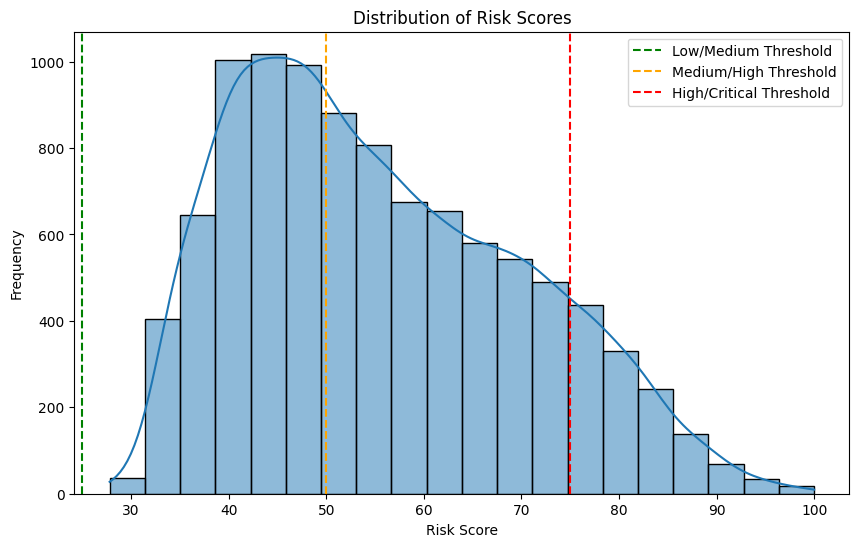

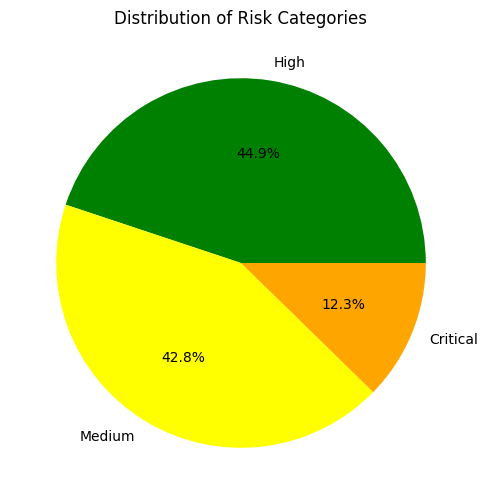

<Figure size 1000x600 with 0 Axes>

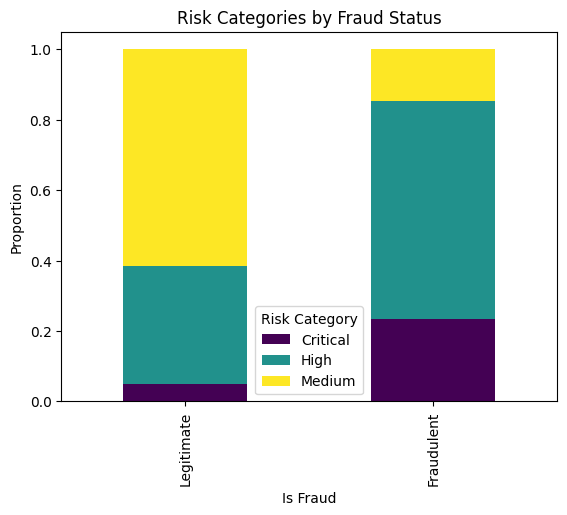

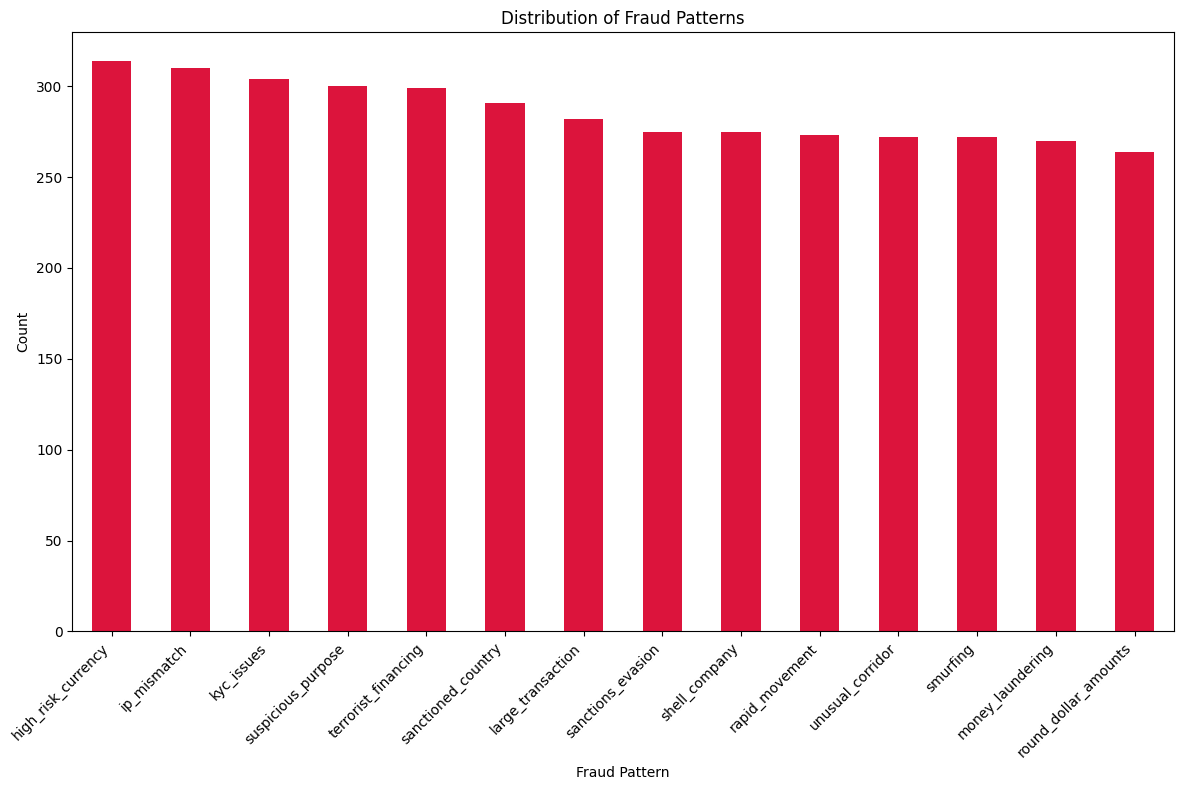

In [28]:
# Analyze risk score distribution
plt.figure(figsize=(10, 6))
sns.histplot(synthetic_df['risk_score'], bins=20, kde=True)
plt.title('Distribution of Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.axvline(x=25, color='green', linestyle='--', label='Low/Medium Threshold')
plt.axvline(x=50, color='orange', linestyle='--', label='Medium/High Threshold')
plt.axvline(x=75, color='red', linestyle='--', label='High/Critical Threshold')
plt.legend()
plt.show()

# Risk category distribution
plt.figure(figsize=(8, 6))
synthetic_df['risk_category'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                                colors=['green', 'yellow', 'orange', 'red'])
plt.title('Distribution of Risk Categories')
plt.ylabel('')
plt.show()

# Fraud vs. Risk Category
plt.figure(figsize=(10, 6))
fraud_by_risk = pd.crosstab(synthetic_df['is_fraud'], synthetic_df['risk_category'], normalize='index')
fraud_by_risk.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Risk Categories by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.legend(title='Risk Category')
plt.show()

# Fraud pattern distribution
if 'fraud_pattern' in synthetic_df.columns:
    plt.figure(figsize=(12, 8))
    fraud_patterns_count = synthetic_df[synthetic_df['is_fraud'] == 1]['fraud_pattern'].value_counts()
    fraud_patterns_count.plot(kind='bar', color='crimson')
    plt.title('Distribution of Fraud Patterns')
    plt.xlabel('Fraud Pattern')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

C:\Users\50060\AppData\Local\Temp\ipykernel_29628\3207529074.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_risk_df = synthetic_df.groupby(['sender_country', 'recipient_country']).size().unstack().fillna(0)


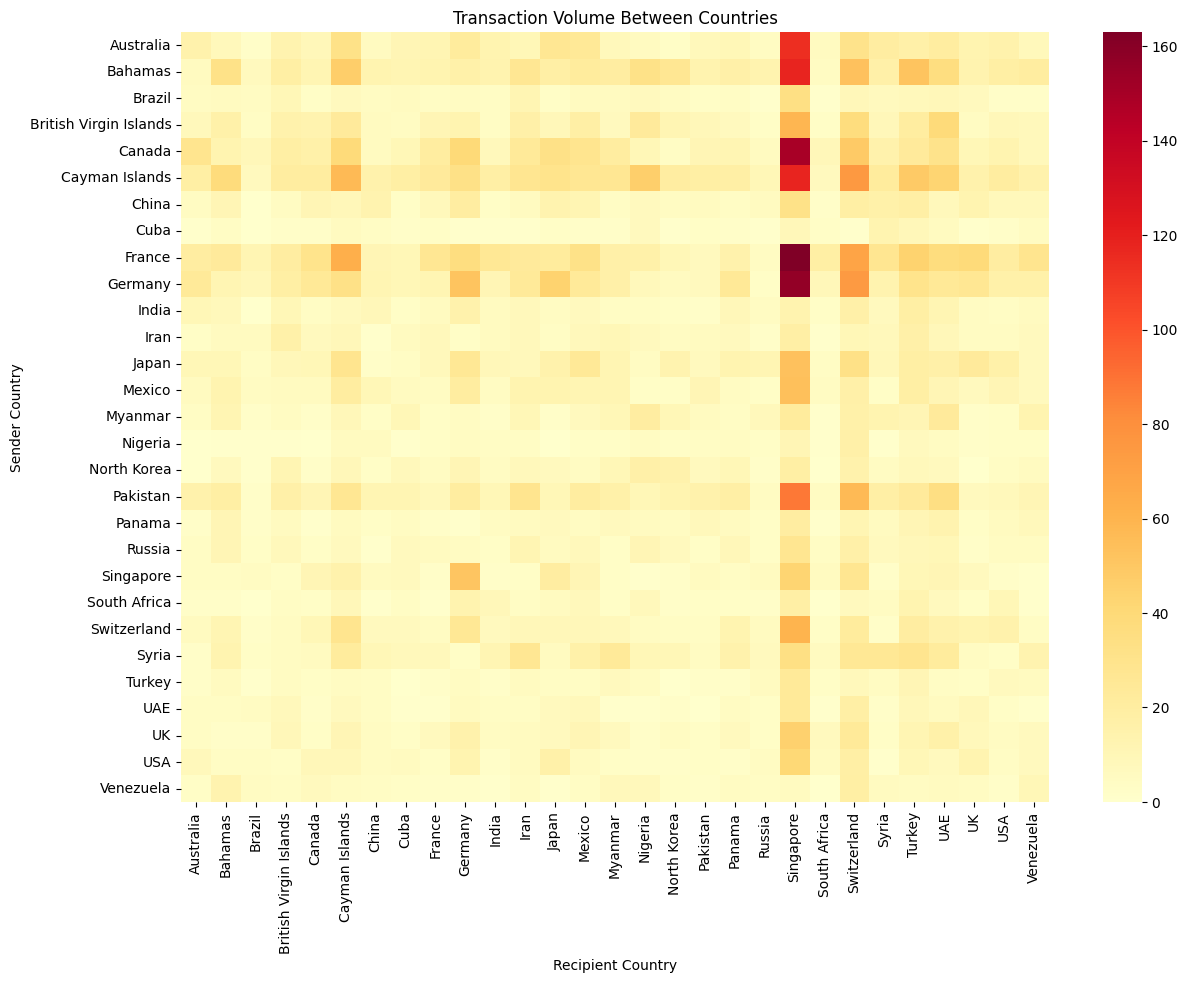

C:\Users\50060\AppData\Local\Temp\ipykernel_29628\3207529074.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_avg_risk = synthetic_df.groupby(['sender_country', 'recipient_country'])['risk_score'].mean().reset_index()


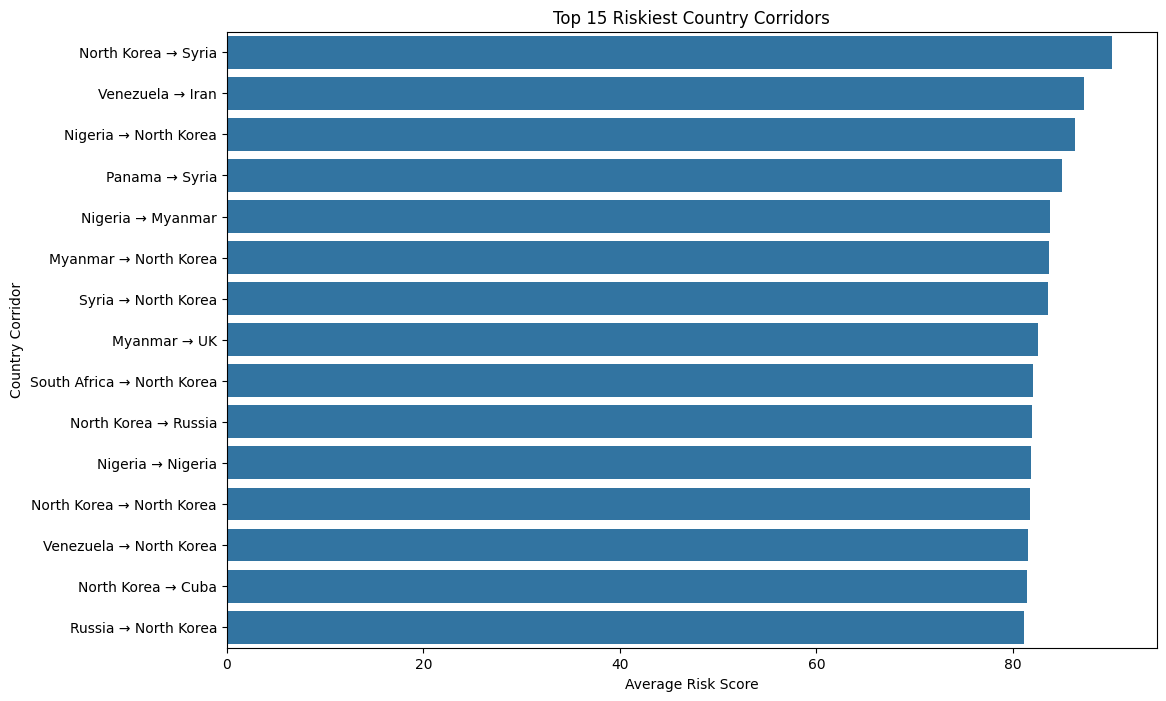

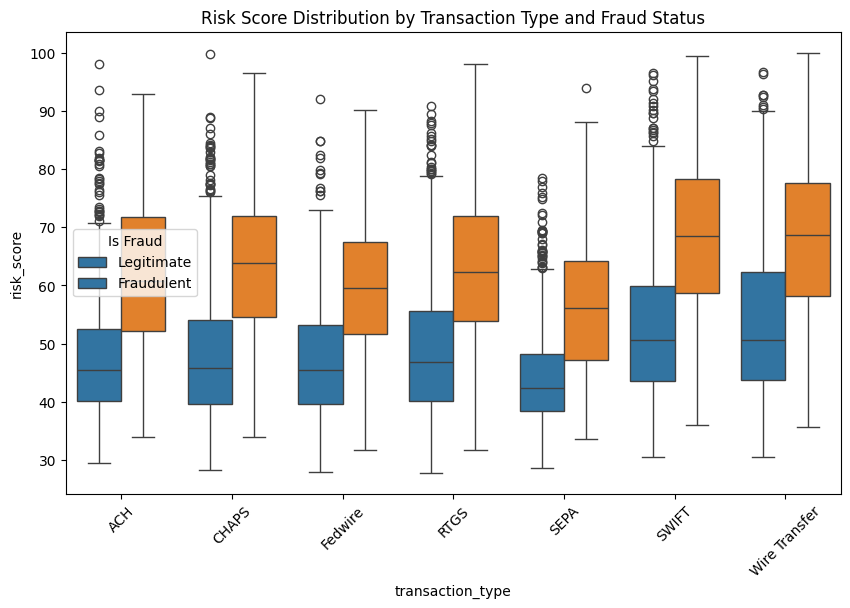

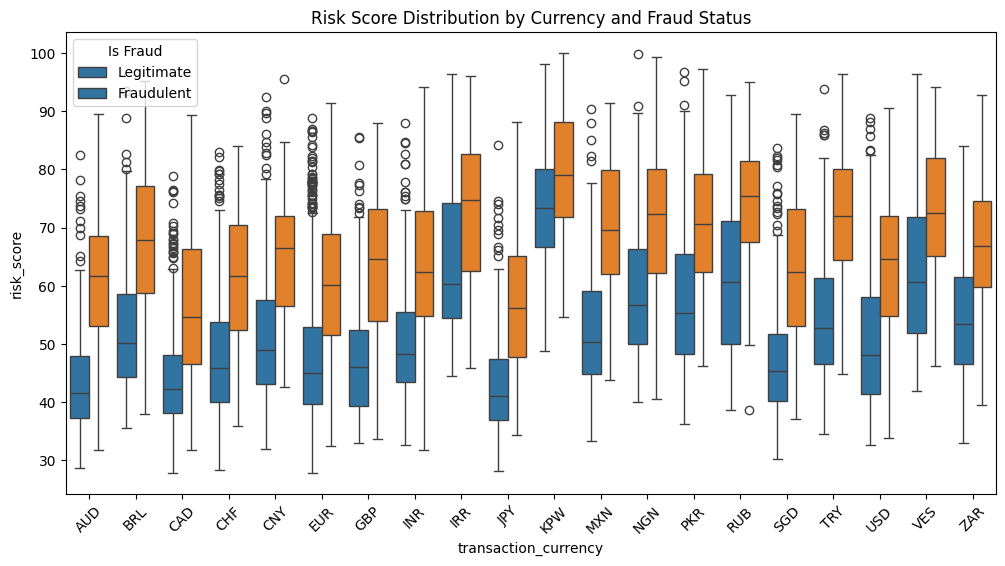

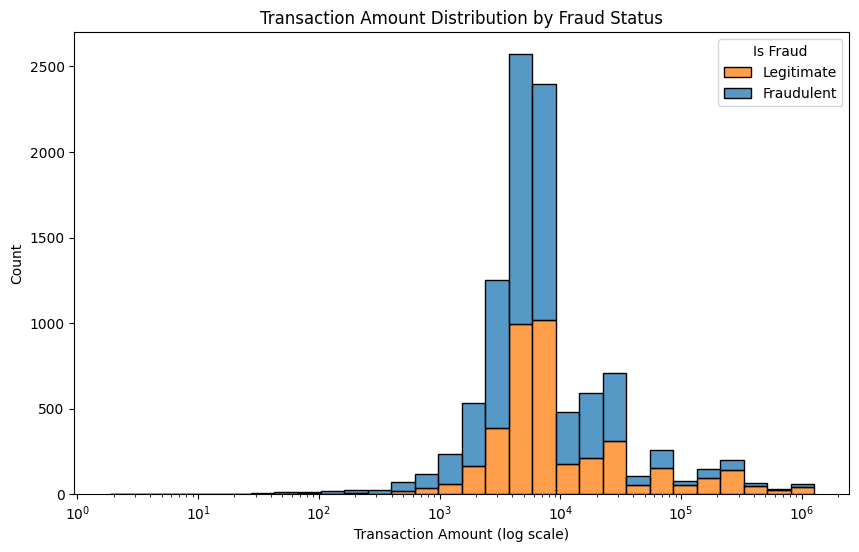

In [29]:
# Country risk heatmap
plt.figure(figsize=(14, 10))
country_risk_df = synthetic_df.groupby(['sender_country', 'recipient_country']).size().unstack().fillna(0)
sns.heatmap(country_risk_df, cmap='YlOrRd')
plt.title('Transaction Volume Between Countries')
plt.xlabel('Recipient Country')
plt.ylabel('Sender Country')
plt.show()

# Average risk score by country pair
country_avg_risk = synthetic_df.groupby(['sender_country', 'recipient_country'])['risk_score'].mean().reset_index()
top_risky_corridors = country_avg_risk.sort_values('risk_score', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_risky_corridors, x='risk_score', 
           y=top_risky_corridors.apply(lambda x: f"{x['sender_country']} → {x['recipient_country']}", axis=1))
plt.title('Top 15 Riskiest Country Corridors')
plt.xlabel('Average Risk Score')
plt.ylabel('Country Corridor')
plt.show()

# Risk by transaction type
plt.figure(figsize=(10, 6))
sns.boxplot(data=synthetic_df, x='transaction_type', y='risk_score', hue='is_fraud')
plt.title('Risk Score Distribution by Transaction Type and Fraud Status')
plt.xticks(rotation=45)
plt.legend(title='Is Fraud', labels=['Legitimate', 'Fraudulent'])
plt.show()

# Risk by currency
plt.figure(figsize=(12, 6))
sns.boxplot(data=synthetic_df, x='transaction_currency', y='risk_score', hue='is_fraud')
plt.title('Risk Score Distribution by Currency and Fraud Status')
plt.xticks(rotation=45)
plt.legend(title='Is Fraud', labels=['Legitimate', 'Fraudulent'])
plt.show()

# Transaction amount distribution by fraud status
plt.figure(figsize=(10, 6))
sns.histplot(data=synthetic_df, x='transaction_amount', hue='is_fraud', 
            multiple='stack', bins=30, log_scale=True)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Transaction Amount (log scale)')
plt.ylabel('Count')
plt.legend(title='Is Fraud', labels=['Legitimate', 'Fraudulent'])
plt.show()